## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import warnings

## Loading the dataset

In [2]:
import requests, zipfile, io
zipfile.ZipFile(io.BytesIO(requests.get('http://files.grouplens.org/datasets/movielens/ml-latest-small.zip').content)).extractall()

movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

In [3]:
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [4]:
filtered_movies = movies[movies['title'].str.contains("godfather", case=False)]
filtered_movies

movieId                                    title  \
659       858                    Godfather, The (1972)   
922      1221           Godfather: Part II, The (1974)   
1498     2023          Godfather: Part III, The (1990)   
5248     8607                  Tokyo Godfathers (2003)   
9541   172591  The Godfather Trilogy: 1972-1990 (1992)   

                            genres  
659                    Crime|Drama  
922                    Crime|Drama  
1498  Crime|Drama|Mystery|Thriller  
5248     Adventure|Animation|Drama  
9541            (no genres listed)

## Exploratory data analysis

In [5]:
df = movies.merge(ratings , on='movieId')
df.head()

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating   timestamp  
0       1     4.0   964982703  
1       5     4.0   847434962  
2       7     4.5  1106635946  
3      15     2.5  1510577970  
4      17     4.5  1305696483

In [6]:
movies_count = df['movieId'].nunique()
users_count = df['userId'].nunique()
print("Number of movies:", movies_count)
print("Number of users:", users_count)
num_rows = df.shape[0]
print("Number of ratings:", num_rows)
print("average ratings per user:",num_rows /users_count)

Number of movies: 9724
Number of users: 610
Number of ratings: 100836
average ratings per user: 165.30491803278687


all users have at least 20 ratings


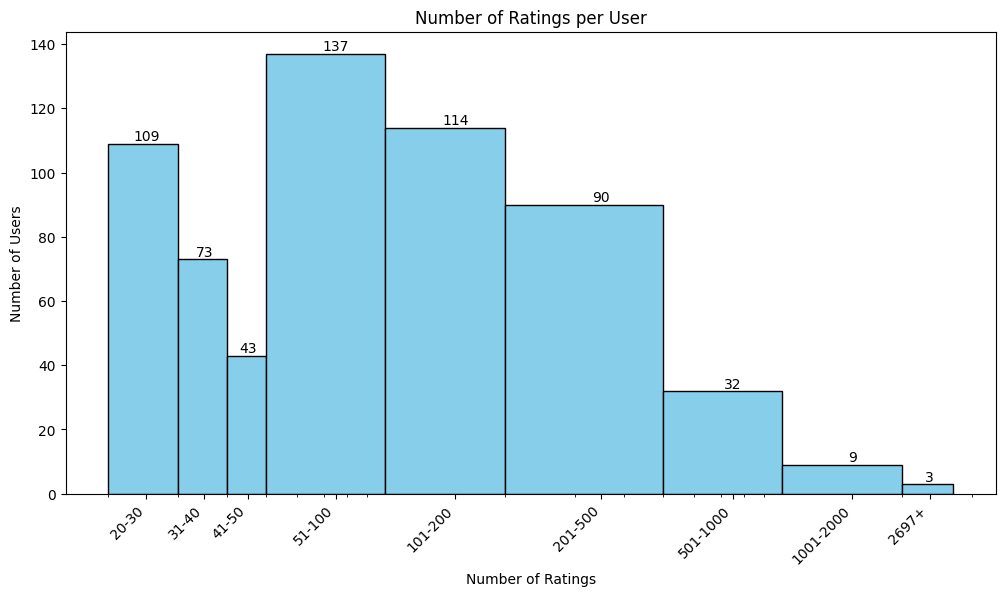

In [7]:
ratings_per_user = df.groupby('userId')['movieId'].count()
min_ratings = ratings_per_user.min()
print("all users have at least", min_ratings ,"ratings")
# Define bins for ranges
bins = [20, 30, 40, 50, 100, 200, 500, 1000, 2000, ratings_per_user.max()]  # Start from 20

# Plot the histogram of ratings per user
plt.figure(figsize=(12, 6))
hist, bins, _ = plt.hist(ratings_per_user, bins=bins, color='skyblue', edgecolor='black')
plt.xscale('log')  # Log scale for better visualization

# Labeling the x-axis ticks with actual values
tick_labels = ['20-30', '31-40', '41-50', '51-100', '101-200', '201-500', '501-1000', '1001-2000', f'{ratings_per_user.max() - 1}+']
tick_positions = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins)-1)]
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')

# Add text annotations on top of each bar
for i, count in enumerate(hist):
    plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, count, str(int(count)), ha='center', va='bottom', fontsize=10, color='black')

plt.show()


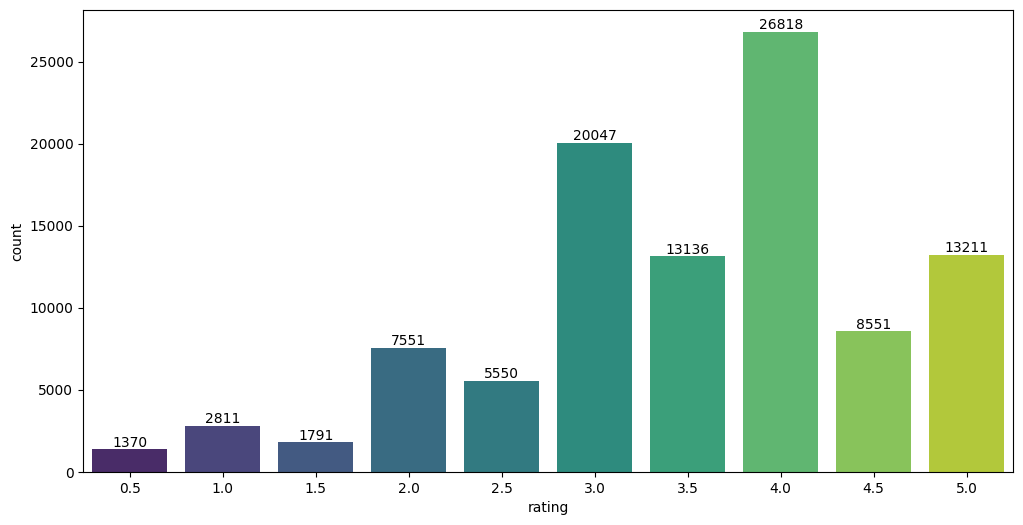

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    # Plot a countplot to visualize the distribution of ratings
    plt.figure(figsize=(12, 6))
    sns.countplot(x='rating', data=df, palette='viridis')
    
    # Annotate each bar with its count value
    for p in plt.gca().patches:
        plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                           textcoords='offset points')


    plt.show()

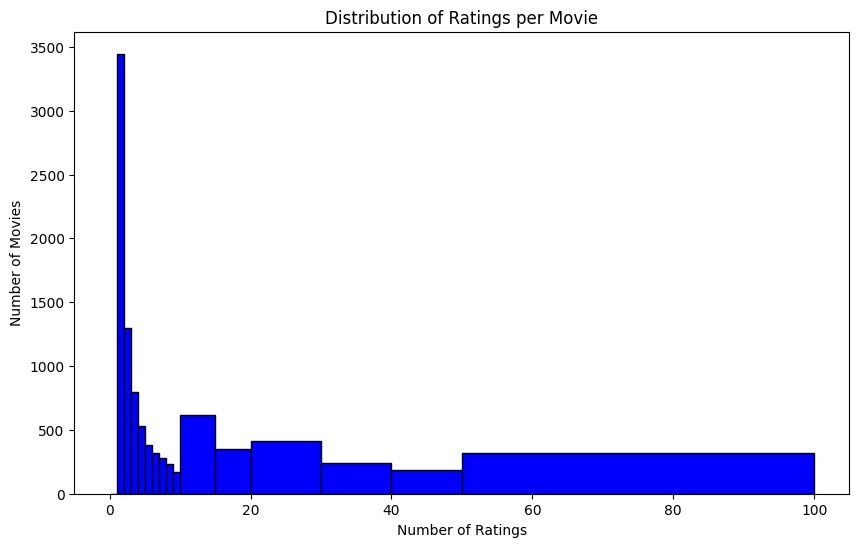

In [9]:
ratings_per_movie = df.groupby('movieId')['userId'].count()
per_movie_ratings_count = ratings_per_movie.tolist()

# Specify the number of bins or ranges
num_bins = 20

# Specify custom ranges
custom_ranges = [0,1,2,3,4,5,6,7,8,9, 10,15, 20, 30, 40, 50, 100]

# Plotting histogram with custom ranges
plt.figure(figsize=(10, 6))
plt.hist(per_movie_ratings_count, bins=custom_ranges, color='blue', edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Distribution of Ratings per Movie')

plt.show()
# ratings_per_movie

In [10]:
num_movies_above_threshold = sum(count > 20 for count in per_movie_ratings_count)
movies_under_threshold = ratings_per_movie[ratings_per_movie < 20].index.tolist()
len(movies_under_threshold)

8427

In [11]:
movies = movies[~movies["movieId"].isin(movies_under_threshold)]
df = df[~df["movieId"].isin(movies_under_threshold)]

In [12]:
len(df)

67898

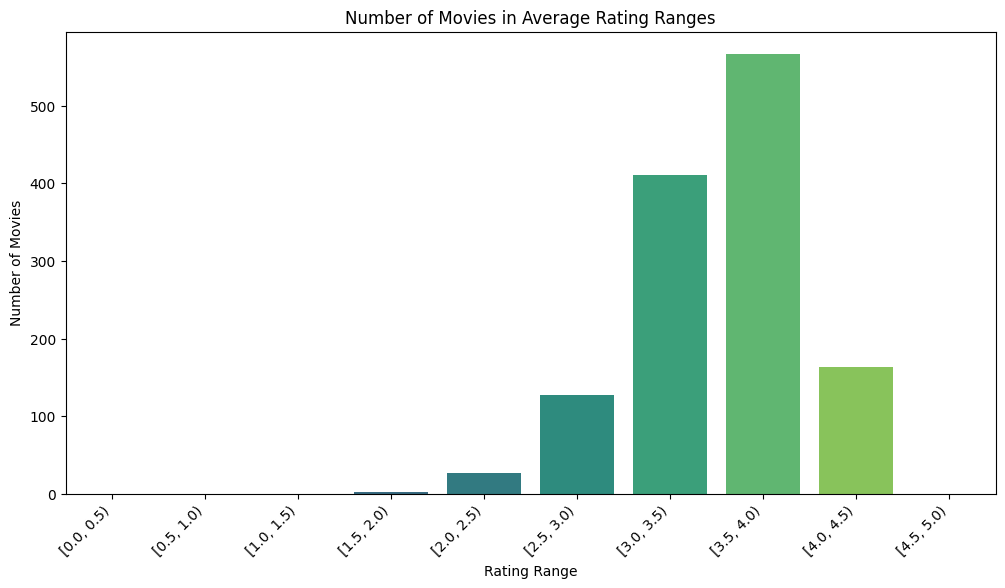

In [13]:

# Calculate average rating per movie
average_rating_per_movie = df.groupby('movieId')['rating'].mean()

# Create bins for rating ranges
bins = [i * 0.5 for i in range(11)]
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    # Bin the average ratings into ranges and count the number of movies in each range
    rating_ranges = pd.cut(average_rating_per_movie, bins, right=False)
    count_per_range = rating_ranges.value_counts().sort_index()
    
    # Plot the count of movies in each rating range
    plt.figure(figsize=(12, 6))
    sns.barplot(x=count_per_range.index.astype(str), y=count_per_range.values, palette='viridis')
    
    # Add labels and title
    plt.title('Number of Movies in Average Rating Ranges')
    plt.xlabel('Rating Range')
    plt.ylabel('Number of Movies')
    
    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    # plt.show()


In [14]:
df.describe()

movieId        userId        rating     timestamp
count   67898.000000  67898.000000  67898.000000  6.789800e+04
mean    12869.939512    316.273189      3.623060  1.195368e+09
std     26771.478528    181.360247      1.005625  2.170279e+08
min         1.000000      1.000000      0.500000  8.281246e+08
25%       849.000000    164.000000      3.000000  9.978125e+08
50%      2193.000000    313.000000      4.000000  1.180447e+09
75%      5418.000000    474.000000      4.000000  1.430332e+09
max    168252.000000    610.000000      5.000000  1.537632e+09

## data preprocessing

#### In the data preprocessing step we : 
- fix the movie title naming issue
- remove the date from movie titles
- choose movies with ratings higher than 3.5 stars and group them per user as our transactions
- drop the genre and timestamp collums (irrelevant to the algorithm)

In [15]:
movies['title'] = movies['title'].str.replace(r'\s*\(\d{4}\)\s*$', '', regex=True)
import pandas as pd

# Assuming 'movies' is your DataFrame and 'title' is the column with movie titles
# Replace 'title' with the actual column name if it's different in your DataFrame

def fix_movie_title(title):
    # Remove leading "The" or "A"
    if title.endswith(", The"):
        title = "The " + title[:-5]
    elif title.endswith(", A"):
        title = "A " + title[:-3]
    return title

# Apply the function to the 'title' column
movies['title'] = movies['title'].apply(fix_movie_title)
movies.head()

movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
4        5  Father of the Bride Part II   
5        6                         Heat   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
4                                       Comedy  
5                        Action|Crime|Thriller

In [16]:
df.drop(['genres' , 'timestamp'] , axis=1 , inplace=True)

In [17]:
df.head()

movieId             title  userId  rating
0        1  Toy Story (1995)       1     4.0
1        1  Toy Story (1995)       5     4.0
2        1  Toy Story (1995)       7     4.5
3        1  Toy Story (1995)      15     2.5
4        1  Toy Story (1995)      17     4.5

In [18]:
# Filter the DataFrame to include only liked movies (rating 3 stars or more)
liked_movies_df = df[df['rating'] >= 3.5]

# Group by 'userId' and aggregate the liked movies into a list
user_liked_movies = liked_movies_df.groupby('userId')['movieId'].agg(list).reset_index()
# user_liked_movies_ids = liked_movies_df.groupby('userId')['movieId'].agg(list).reset_index()

# Rename the column to 'liked_movies'
user_liked_movies.rename(columns={'movieId': 'liked_movies'}, inplace=True)

user_liked_movies


userId                                       liked_movies
0         1  [1, 3, 6, 47, 50, 101, 110, 151, 163, 216, 231...
1         2  [333, 1704, 3578, 6874, 8798, 46970, 48516, 58...
2         3                      [849, 1275, 1587, 2288, 3703]
3         4  [215, 260, 265, 319, 342, 345, 348, 368, 457, ...
4         5  [1, 21, 34, 36, 50, 58, 110, 247, 261, 296, 36...
..      ...                                                ...
604     606  [17, 18, 29, 32, 36, 50, 58, 70, 105, 110, 111...
605     607  [1, 36, 110, 150, 165, 292, 318, 377, 380, 434...
606     608  [10, 16, 21, 32, 34, 47, 50, 110, 145, 170, 17...
607     609                 [10, 253, 296, 318, 356, 457, 590]
608     610  [1, 6, 16, 32, 47, 50, 70, 95, 110, 111, 112, ...

[609 rows x 2 columns]

In [19]:
user_liked_movies

userId                                       liked_movies
0         1  [1, 3, 6, 47, 50, 101, 110, 151, 163, 216, 231...
1         2  [333, 1704, 3578, 6874, 8798, 46970, 48516, 58...
2         3                      [849, 1275, 1587, 2288, 3703]
3         4  [215, 260, 265, 319, 342, 345, 348, 368, 457, ...
4         5  [1, 21, 34, 36, 50, 58, 110, 247, 261, 296, 36...
..      ...                                                ...
604     606  [17, 18, 29, 32, 36, 50, 58, 70, 105, 110, 111...
605     607  [1, 36, 110, 150, 165, 292, 318, 377, 380, 434...
606     608  [10, 16, 21, 32, 34, 47, 50, 110, 145, 170, 17...
607     609                 [10, 253, 296, 318, 356, 457, 590]
608     610  [1, 6, 16, 32, 47, 50, 70, 95, 110, 111, 112, ...

[609 rows x 2 columns]

In [20]:
transactions = user_liked_movies['liked_movies'].tolist()
test_set = transactions[500:600]


## Training

### In the training step we :
- import the apyori library
- generate the association rules
- organize our rules in a dataframe 


In [21]:
import pandas as pd
import pickle

# Define the create_movie_mappings function
def create_movie_mappings(df):
    # Creating a mapping from movieid to moviename
    id_to_name = dict(zip(df['movieId'], df['title']))
    
    # Creating a mapping from moviename to movieid
    name_to_id = dict(zip(df['title'], df['movieId']))
    
    return id_to_name, name_to_id



id_to_name_mapping, name_to_id_mapping = create_movie_mappings(movies)

# Export the mappings using pickle
with open('movie_mappings.pkl', 'wb') as f:
    pickle.dump((id_to_name_mapping, name_to_id_mapping), f)

In [22]:
# importing the library
try:
    import apyori
except:
    !pip install apyori

from apyori import apriori # for association rule learning models

In [23]:
transactions = user_liked_movies['liked_movies'].tolist()
transactions

[[1,
  3,
  6,
  47,
  50,
  101,
  110,
  151,
  163,
  216,
  231,
  235,
  260,
  333,
  349,
  356,
  362,
  367,
  441,
  457,
  480,
  527,
  543,
  552,
  553,
  590,
  592,
  593,
  596,
  608,
  661,
  733,
  919,
  923,
  1025,
  1029,
  1031,
  1032,
  1042,
  1049,
  1060,
  1073,
  1080,
  1089,
  1090,
  1092,
  1097,
  1127,
  1136,
  1196,
  1197,
  1198,
  1206,
  1208,
  1210,
  1213,
  1214,
  1220,
  1222,
  1240,
  1256,
  1265,
  1270,
  1275,
  1278,
  1282,
  1291,
  1298,
  1500,
  1517,
  1552,
  1573,
  1587,
  1617,
  1625,
  1732,
  1777,
  1805,
  1954,
  1967,
  2000,
  2005,
  2012,
  2018,
  2028,
  2046,
  2054,
  2058,
  2078,
  2094,
  2096,
  2105,
  2115,
  2137,
  2139,
  2161,
  2174,
  2193,
  2268,
  2273,
  2291,
  2329,
  2353,
  2366,
  2395,
  2406,
  2427,
  2470,
  2478,
  2502,
  2529,
  2542,
  2571,
  2580,
  2616,
  2628,
  2640,
  2641,
  2692,
  2700,
  2716,
  2761,
  2797,
  2826,
  2858,
  2872,
  2916,
  2944,
  2947,
  2948,
  

In [24]:
rules = apriori(transactions = transactions, min_support=0.00030, min_confidance=0.01, min_lift=2, min_length=2, max_length=2)
#let's transform them into a list
results = list(rules)

def inspect(results):
    '''
    function to put the result in well organised pandas dataframe
    '''
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))

resultsinDataFrame = pd.DataFrame(inspect(results), columns = ['Item #1', 'Item #2', 'Support', 'Confidence', 'Lift'])
resultsinDataFrame.head()


Item #1  Item #2   Support  Confidence      Lift
0        1        3  0.022989    0.084848  2.246640
1        1        5  0.013136    0.048485  2.271329
2        1       19  0.026273    0.096970  2.036364
3        1       24  0.009852    0.036364  2.214545
4        1       34  0.078818    0.290909  2.134502

In [25]:
resultsinDataFrame.to_csv('association_rules.csv', index=False)

## Testing

### In the testiong step we :
- create the recommendations function to genrate the top recommendations for the input movie



In [26]:
def recommendations(film, count = 20) :
    result = resultsinDataFrame[(resultsinDataFrame['Item #1'] == film) | (resultsinDataFrame['Item #2'] == film) ]\
    .nlargest(n=count, columns='Support')
    modified_results = result.copy()
    mask = modified_results['Item #2'] == film
    modified_results.loc[mask, 'Item #2'] = modified_results.loc[mask, 'Item #1']
    recommendations = modified_results[["Item #2" , "Support"]]
    return recommendations["Item #2"].tolist()
    
def multi_recommendation(films):
    combined_results = pd.DataFrame()

    for film in films:
        # Filter the results DataFrame for the current film
        filtered_results = recommendations(film)

        # Append the filtered results to the combined_results DataFrame
        combined_results = pd.concat([combined_results, filtered_results])

    # Reset the index of the combined DataFrame
    combined_results = combined_results.reset_index(drop=True)

    # Filter out rows where 'Item #2' is in the list of input movies
    combined_results = combined_results[~combined_results["Item #2"].isin(films)]

    combined_results = combined_results.drop_duplicates(subset='Item #2')
    # Get the top 20 recommendations based on 'Support'
    combined_results = combined_results.nlargest(n=20, columns='Support')

    return combined_results

## Evaluation 

### In the evaluation step we :
- calculate the recall@20 and precision@20 for our testset
- 



Value of k: 20

 Average Precision@20: 0.2320


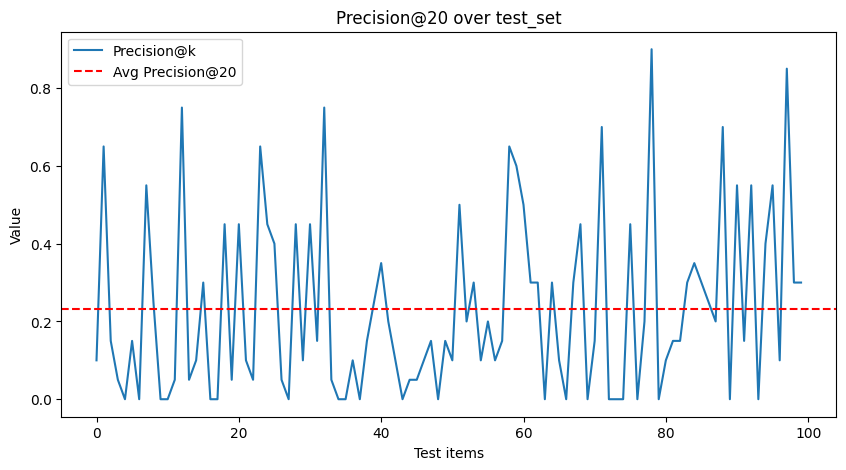

In [55]:
import matplotlib.pyplot as plt


def calculate_recall_precision_at_k(relevant_items, recommended_items, k):
    relevant_set = set(relevant_items)
    recommended_set = set(recommended_items)

    # Calculate recall
    precision_at_k = len(relevant_set.intersection(recommended_set)) / k if k > 0 else 10000

    # Calculate precision
    recall_at_k = len(relevant_set.intersection(recommended_set)) / len(relevant_set) if len(
        relevant_set) > 0 else 1000000

    return recall_at_k, precision_at_k

# Set the desired value of k
k = 20

# Print the value of k
print(f"Value of k: {k}")

# Initialize sums for recall and precision
recall_sum = 0
precision_sum = 0

# Lists to store recall and precision values for each iteration
recall_values = []
precision_values = []

# Loop over a subset of the test set (from index 20 to 40)
for user_data in test_set:
    # Extract relevant items for the user
    relevant_items = user_data

    # Get recommendations using your recommendation function (replace with your actual function)
    recommendations_list = recommendations(user_data[0], k)[:k]

    # Calculate recall and precision at k
    recall_at_k, precision_at_k = calculate_recall_precision_at_k(relevant_items, recommendations_list, k)

    # Display the count of recommendations and a visual representation of precision
    # print(f"Count of Recommendations: {len(recommendations_list)} | Precision: {'#' * int(precision_at_k * 100)}")

    # If there are recommendations, update sums
    if len(recommendations_list) > 0:
        recall_sum += recall_at_k
        precision_sum += precision_at_k

        # Append recall and precision values to the lists
        recall_values.append(recall_at_k)
        precision_values.append(precision_at_k)
    else:
        print("No recommendations")

# Calculate and print average recall and precision over the loop
average_recall = recall_sum / len(test_set)
average_precision = precision_sum / len(test_set)
print(f"\n Average Precision@{k}: {average_precision:.4f}")

# Plotting
plt.figure(figsize=(10, 5))
# plt.plot(recall_values, label='Recall@k')
plt.plot(precision_values, label='Precision@k')
plt.axhline(y=average_precision, color='r', linestyle='--', label=f'Avg Precision@{k}')
plt.xlabel('Test items')
plt.ylabel('Value')
plt.title(f'Precision@{k} over test_set')
plt.savefig('plots/precision_plot.png')
plt.legend()
plt.show()

In [28]:
## function to get recommendations as movie titles (strings) instea of ids
def recommendations_name(film):
    result_ids = recommendations(name_to_id_mapping.get(film))
    result_titles = []
    for id in result_ids :
        result_titles.append(id_to_name_mapping.get(id))
    return result_titles
        

In [88]:
# Example movie_name (case sensitive)
movie_name = 'The Departed'

# Get recommendations using your function
movie_recommendations = recommendations_name(movie_name)

# Create a DataFrame with the recommendations
recommendations_df = pd.DataFrame({ 'Recommendations': movie_recommendations})

# Print the DataFrame
print("Movie Name : ", movie_name)
recommendations_df[0:11]

Movie Name :  The Departed


Recommendations
0                                          Fight Club
1                                     The Dark Knight
2                                       The Godfather
3                                             Memento
4                                           Inception
5                                  The Usual Suspects
6       The Lord of the Rings: The Return of the King
7   The Lord of the Rings: The Fellowship of the Ring
8                                 Catch Me If You Can
9                                  American History X
10              The Lord of the Rings: The Two Towers